In [283]:
import pandas as pd

train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

train.head()

,L_Id,Date of Creation,Agent Category Assigned,Type of Request,Description of the Request,Location,Street Type,Region Type,Ward No,Estimated Date of Completion,Request Solution Category,Actual Date of Completion,Team Assigned,A_1,A_2,Problem Category
0,LM_1,18-12-2018 00:29,1,10,2,13,11223.0,0,7,18-12-2018 09:29,4,18-12-2018 05:34,45,1,1,1
1,LM_2,30-11-2018 22:19,1,15,17,13,10019.0,0,30,01-12-2018 07:19,8,01-12-2018 00:35,22,2,2,1
2,LM_3,12-12-2018 02:37,1,11,22,0,11237.0,2,7,12-12-2018 11:37,8,12-12-2018 04:29,17,1,1,1
3,LM_4,26-12-2018 01:45,1,11,22,12,11213.0,0,7,26-12-2018 10:45,7,26-12-2018 05:26,33,1,1,1
4,LM_5,24-12-2018 03:22,1,2,27,13,10460.0,0,6,24-12-2018 12:22,4,24-12-2018 10:20,24,0,0,1


#**Exploratory Data Analysis**

In [284]:
train.isnull().sum()

L_Id                              0
Date of Creation                  0
Agent Category Assigned           0
Type of Request                   0
Description of the Request        0
Location                          0
Street Type                     419
Region Type                       0
Ward No                           0
Estimated Date of Completion      0
Request Solution Category         0
Actual Date of Completion       432
Team Assigned                     0
A_1                               0
A_2                               0
Problem Category                  0
dtype: int64

In [285]:
train['Street Type'] = train['Street Type'].fillna(train['Street Type'].mean())

In [286]:
train.isnull().sum()

L_Id                              0
Date of Creation                  0
Agent Category Assigned           0
Type of Request                   0
Description of the Request        0
Location                          0
Street Type                       0
Region Type                       0
Ward No                           0
Estimated Date of Completion      0
Request Solution Category         0
Actual Date of Completion       432
Team Assigned                     0
A_1                               0
A_2                               0
Problem Category                  0
dtype: int64

#**Checking Dataset SkewNess**

In [287]:
# Checking Problem Category wise Data frequency 
print('Problem Category frequency :')
print(train['Problem Category'].value_counts(normalize=True))
print(' ')
print('Problem Category count :')
print(train['Problem Category'].value_counts())

Problem Category frequency :
1    0.931977
2    0.046746
0    0.021277
Name: Problem Category, dtype: float64
 
Problem Category count :
1    6001
2     301
0     137
Name: Problem Category, dtype: int64


In [288]:
train.describe()

,Agent Category Assigned,Type of Request,Description of the Request,Location,Street Type,Region Type,Ward No,Request Solution Category,Team Assigned,A_1,A_2,Problem Category
count,6439.0,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000
mean,1.0,7.807579,22.504892,12.054822,10885.853654,0.555676,19.020966,6.686442,28.230005,1.992856,1.992856,1.025470
std,0.0,5.033016,11.012981,3.069295,522.061787,1.160858,13.646950,2.842832,18.073382,1.338121,1.338121,0.259586
min,1.0,0.000000,0.000000,0.000000,10001.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,2.000000,15.000000,13.000000,10457.000000,0.000000,7.000000,4.000000,13.000000,1.000000,1.000000,1.000000
50%,1.0,10.000000,25.000000,13.000000,11207.000000,0.000000,13.000000,7.000000,28.000000,2.000000,2.000000,1.000000
75%,1.0,11.000000,30.000000,13.000000,11237.000000,0.000000,30.000000,8.000000,44.000000,3.000000,3.000000,1.000000
max,1.0,20.000000,41.000000,16.000000,11694.000000,5.000000,49.000000,15.000000,66.000000,5.000000,5.000000,2.000000


As we can see Values for StreetType, WardNo and TeamAssigned is of high range compare to other columns. 

Lets scale these values :

In [289]:
#Normalized Data
train['MinMax_StreetType'] = (train['Street Type']-min(train['Street Type']))/(max(train['Street Type'])-min(train['Street Type']))
train['MinMax_WardNo'] = (train['Ward No']-min(train['Ward No']))/(max(train['Ward No'])-min(train['Ward No']))
train['MinMax_TeamAssigned'] = (train['Team Assigned']-min(train['Team Assigned']))/(max(train['Team Assigned'])-min(train['Team Assigned']))

train.drop(['L_Id', 'Street Type', 'Ward No', 'Team Assigned', 'Description of the Request'], axis=1, inplace=True)

In [290]:
train.describe()

,Agent Category Assigned,Type of Request,Location,Region Type,Request Solution Category,A_1,A_2,Problem Category,MinMax_StreetType,MinMax_WardNo,MinMax_TeamAssigned
count,6439.0,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000,6439.000000
mean,1.0,7.807579,12.054822,0.555676,6.686442,1.992856,1.992856,1.025470,0.522654,0.388183,0.427727
std,0.0,5.033016,3.069295,1.160858,2.842832,1.338121,1.338121,0.259586,0.308365,0.278509,0.273839
min,1.0,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.0,2.000000,13.000000,0.000000,4.000000,1.000000,1.000000,1.000000,0.269344,0.142857,0.196970
50%,1.0,10.000000,13.000000,0.000000,7.000000,2.000000,2.000000,1.000000,0.712345,0.265306,0.424242
75%,1.0,11.000000,13.000000,0.000000,8.000000,3.000000,3.000000,1.000000,0.730065,0.612245,0.666667
max,1.0,20.000000,16.000000,5.000000,15.000000,5.000000,5.000000,2.000000,1.000000,1.000000,1.000000


Dataset is highly skewed. 
I will go for technique to deal with imbalanced Dataset.

We have two options here : 
(1) UnderSampling
(2) OverSampling

Let's try Undersampling first : 

In [292]:
# Problem Category count :
#1    6001
#2     301
#0     137

ProbCategory_0 = train.loc[train['Problem Category'] == 0]
ProbCategory_1 = train.loc[train['Problem Category'] == 1][:300]
ProbCategory_2 = train.loc[train['Problem Category'] == 2]

normal_distributed_df = pd.concat([ProbCategory_0, ProbCategory_1, ProbCategory_2])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,Date of Creation,Agent Category Assigned,Type of Request,Location,Region Type,Estimated Date of Completion,Request Solution Category,Actual Date of Completion,A_1,A_2,Problem Category,MinMax_StreetType,MinMax_WardNo,MinMax_TeamAssigned
170,12-12-2018 19:52,1,15,13,2,13-12-2018 04:52,10,13-12-2018 00:42,2,2,1,0.037803,0.612245,0.515152
216,07-12-2018 15:09,1,10,13,2,08-12-2018 00:09,4,07-12-2018 19:02,3,3,1,0.998228,0.285714,0.833333
100,01-12-2018 19:56,1,2,13,0,02-12-2018 04:56,8,02-12-2018 00:34,0,0,1,0.269344,0.122449,0.303030
1638,22-07-2018 15:04,1,13,7,4,23-07-2018 00:04,12,NaN,5,5,2,0.522654,0.632653,0.000000
23,22-12-2018 20:45,1,11,0,0,23-12-2018 05:45,7,24-12-2018 05:58,2,2,1,0.001181,0.612245,0.121212


In [293]:
new_df.shape

(738, 14)

#**Working on Date Columns**

In [294]:
from datetime import datetime, timedelta, date
DiffBetDateOfCreation_ExpectedTime = []
for ind in new_df.index: 
  #print(new_df['Date of Creation'][ind])
  DateOfCreation = datetime.strptime(new_df['Date of Creation'][ind], '%d-%m-%Y %H:%M')
  #print(DateOfCreation)
  ExpectedDate = datetime.strptime(new_df['Estimated Date of Completion'][ind], '%d-%m-%Y %H:%M')
  #print(ExpectedDate)
  DiffBetDateOfCreation_ExpectedTime.append((ExpectedDate - DateOfCreation).total_seconds() / 60)

In [295]:
new_df['DateCreation_EstimatedDate'] = DiffBetDateOfCreation_ExpectedTime

In [296]:
new_df['DateCreation_EstimatedDate'].value_counts()

540.0    738
Name: DateCreation_EstimatedDate, dtype: int64

So, We can say that for all the entries Estimated time has been added as 540 minutes from the time when an entry is being made into dataset ie. [Date of Creation]. Hence this column will be of no use interms ot Problem Category classification.

In [297]:
new_df.drop(['Estimated Date of Completion', 'DateCreation_EstimatedDate'], axis=1, inplace=True)

In [298]:
new_df.head()
new_df.shape

(738, 13)

In [299]:
from datetime import datetime, timedelta, date
DiffBetDateOfCreation_ActualTime = []
for ind in new_df.index: 
  #print(new_df['Date of Creation'][ind])
  DateOfCreation = datetime.strptime(new_df['Date of Creation'][ind], '%d-%m-%Y %H:%M')
  #print(DateOfCreation)
  try:
    ActualDate = datetime.strptime(new_df['Actual Date of Completion'][ind], '%d-%m-%Y %H:%M')
    DiffBetDateOfCreation_ActualTime.append((ActualDate - DateOfCreation).total_seconds() / 60)
    print('done')
  except:
    print(new_df['Actual Date of Completion'][ind])
    DiffBetDateOfCreation_ActualTime.append(0)
  
  #DiffBetDateOfCreation_ActualTime.append((ActualDate - DateOfCreation).total_seconds() / 60)

done
done
done
nan
done
done
nan
done
nan
nan
done
nan
nan
nan
done
nan
done
nan
done
nan
done
nan
done
nan
nan
nan
nan
nan
nan
nan
done
nan
nan
done
done
nan
nan
nan
done
nan
nan
done
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
done
nan
done
nan
nan
done
nan
nan
nan
done
done
done
done
nan
done
done
done
done
nan
nan
nan
nan
done
nan
done
done
done
nan
done
nan
done
nan
done
done
nan
nan
nan
nan
nan
nan
nan
nan
nan
done
done
nan
done
nan
done
done
done
nan
done
nan
nan
nan
done
done
nan
nan
nan
done
done
done
done
nan
nan
nan
nan
nan
nan
nan
nan
done
nan
nan
done
nan
done
nan
done
done
done
done
nan
done
nan
done
done
nan
nan
nan
nan
done
nan
done
done
done
nan
done
nan
done
done
nan
nan
done
nan
done
nan
done
done
done
nan
done
nan
nan
done
nan
nan
nan
done
nan
nan
done
done
nan
nan
nan
nan
done
nan
nan
nan
nan
nan
nan
nan
nan
done
done
done
done
done
nan
nan
nan
done
done
nan
nan
nan
done
done
nan
done
done
nan
done
done
nan
done
nan
nan
done
done
nan
done
nan
nan
done
nan
done
nan
done

In [300]:
new_df['DateCreation_ActualDate'] = DiffBetDateOfCreation_ActualTime

---- Not able to decide what to do with this column... 
Let'z drop Actual Date column as of now ---- 

In [301]:
new_df.drop(['Date of Creation', 'Actual Date of Completion', 'DateCreation_ActualDate'], axis=1, inplace=True)

In [302]:
new_df.head()

,Agent Category Assigned,Type of Request,Location,Region Type,Request Solution Category,A_1,A_2,Problem Category,MinMax_StreetType,MinMax_WardNo,MinMax_TeamAssigned
170,1,15,13,2,10,2,2,1,0.037803,0.612245,0.515152
216,1,10,13,2,4,3,3,1,0.998228,0.285714,0.833333
100,1,2,13,0,8,0,0,1,0.269344,0.122449,0.303030
1638,1,13,7,4,12,5,5,2,0.522654,0.632653,0.000000
23,1,11,0,0,7,2,2,1,0.001181,0.612245,0.121212


In [303]:
new_df.isnull().sum()

Agent Category Assigned      0
Type of Request              0
Location                     0
Region Type                  0
Request Solution Category    0
A_1                          0
A_2                          0
Problem Category             0
MinMax_StreetType            0
MinMax_WardNo                0
MinMax_TeamAssigned          0
dtype: int64

#**Correlation Matrix**

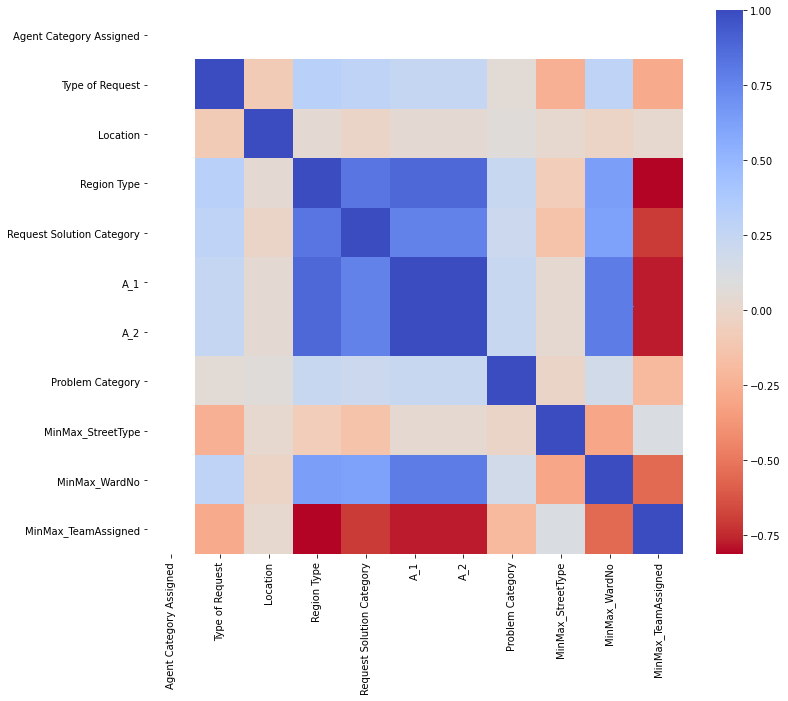

In [304]:
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
rcParams['figure.figsize'] = 12, 10

sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20})
plt.show()

As we can see "Region_Type", "Request_Solution_Category", "A_1", "A_2", "MinMax_WardNo" and "Probelm Category" columns are positively correlated with each other.. 

# **Applying Classifiers**

In [306]:
new_df_temp = new_df

# Splitting Independent and Dependent Variables
X = new_df_temp.loc[:, new_df_temp.columns != 'Problem Category'].values
y = new_df_temp['Problem Category'].values

In [307]:
from sklearn.model_selection import train_test_split

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [308]:
from sklearn.linear_model import LogisticRegression
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)

predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print(score)

0.8


In [309]:
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings(module='sklearn*', action='ignore', category=DeprecationWarning)
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

dtree_model = DecisionTreeClassifier(max_depth=2).fit(X_train, y_train)   #Optimum Value for max_depth : 10
dtree_predictions = dtree_model.predict(X_test)

print('Accuracy : ', accuracy_score(y_test, dtree_predictions))

Accuracy :  0.8216216216216217


In [310]:
rf_clf = RandomForestClassifier(n_estimators=100, max_depth=2, random_state=0)   
rf_clf.fit(X_train, y_train)
rf_predictions = rf_clf.predict(X_test)
    
print('Accuracy : ', accuracy_score(y_test, rf_predictions))

Accuracy :  0.8162162162162162


In [311]:
xg_cl = xgb.XGBClassifier(objective= "multi:softprob", 
                          n_estimators=1000, 
                          learning_rate=0.1, 
                          seed=123,
                          max_depth=2)

xg_cl.fit(X_train, y_train)

preds = xg_cl.predict(X_test)
        
print('Accuracy : ', accuracy_score(y_test, preds))

Accuracy :  0.8162162162162162
